# Ozone project - Polar Ozone Responses to Vulcanic Eruprions


**Student:**
Sigrid Marie Vildskog Auganæs, University of Oslo

**Date:** ...

**Assistant:** Zhihong Zhou

### **Abstract**

text


### **Table of Contents**

text

### __1.0 Introduction__

Vulcanic eruptions release both gasses and aerosol particles into the atmosphere. If these compounds reach et stratosphere they can form particles that reflect inncomming shortwave solar radiaton, or absorbe longwave radiation which can cool the surface and warm the stratosphere. Stratospheric vulcanic aerosols can also disturb the ozone consentration, by providing a surface wich hetrogenious ozone depleating reactions can take place. 


This study intends to investigate the arctic ozone response to vulcanic eruptions in the NorESM, and the difference between present day and pre-CFC conditions. Three different experimental runs of NorESM will be used to study the response around two of the biggest vulcanic eruptions in recorded history, Krakatoa (1883) and mt. Pinatubo (1991). Two of the experimental runs is available from 1970 to 2014, capturing the mt. Pinatubo erruption with no vulcanic forcing, or 90% SO2 and 10% SO4 injection. The last experimental run is from 1850 to 1899, capturing Krakatoa with vulcanic forcing.



### **2.0 Methods**

#### 2.1 Importing packages

In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
%matplotlib inline

from Sigrid_funktions import *

#### 2.2 Accessing data from bucket

In [2]:
import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [3]:
#List of files and variables

#Present day, Pinatubo 
#From experiment 14
#Columb O3
o3_cb_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/cb_O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Temperature
t_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/T.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Columb Sulfate
so4_cb_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/cb_SULFATE.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#AOD sulfate 
aod_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/D550_SO4.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Ozone layers
o3_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#Sulfate in layers
so4_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/mmr_SULFATE.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'
#SO2
so2_14 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14/SO2.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test14.cam.h0.197001-201412.nc'

#From experiment 16
#Columb O3
o3_cb_16 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16/cb_O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16.cam.h0.197001-201412.nc'
#Ozone layers
o3_16 = 's3://escience2022/Zhihong/NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16/O3.NFHISTnorpddmsbc_tropstratchem_f09_mg17_20220105_test16.cam.h0.197001-201412.nc'


#Pre-CFC's, Krakatao
#Columb O3
o3_cb_pre = 's3://escience2022/Zhihong/NHISTvsls/cb_O3.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#AOD sulfate
aod_pre = 's3://escience2022/Zhihong/NHISTvsls/D550_SO4.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#Sulfate in layers
so4_pre = 's3://escience2022/Zhihong/NHISTvsls/mmr_SULFATE.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'
#O3 in layers
o3_pre = 's3://escience2022/Zhihong/NHISTvsls/O3.NHISTvsls_tropstratchem_prep_f09_nt14_20220223_test01.cam.h0.185001-189912.nc'



#### 2.3 Analysis method

##### 2.3.1 Weighted means

In [4]:
def computeWeightedMean(data):
    # Compute weights based on the xarray you use
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    # Compute weighted mean
    air_weighted = data.weighted(weights)
    weighted_mean = air_weighted.mean(("lon", "lat"))
    return weighted_mean

##### 2.3.2 Anomalies and climatologies

In [5]:
def calc_monthly_anomaly(data,end_prior_eruption):
    start = data.time[0].values
    end_prior_eruption = cftime.DatetimeNoLeap(end_prior_eruption,1,15)
    ds_post_eruption = data
    ds_climatology = data.sel(time=slice(start,end_prior_eruption)).groupby('time.month').mean('time', keep_attrs=True)
    ds_anomaly = ds_post_eruption.groupby('time.month') - ds_climatology
    ds_anomaly.attrs = ds_climatology.attrs
    return ds_anomaly

##### 2.3.3 Time periods

In [6]:
#Pinatubo
start_pina = cftime.DatetimeNoLeap(1985,1,15)
end_prior_eruption_pina = cftime.DatetimeNoLeap(1991,1,15)
end_pina = cftime.DatetimeNoLeap(1996,1,15)

#Krakatao
start_krak = cftime.DatetimeNoLeap(1878,1,15)
end_prior_eruption_krak = cftime.DatetimeNoLeap(1882,1,15)
end_krak = cftime.DatetimeNoLeap(1887,1,15)

### **3.0 Results and Discussion**

text and code


In [7]:
da = xr.open_dataset(s3.open(aod_14))
dp = da['D550_SO4']

db = xr.open_dataset(s3.open(aod_pre))
dk = db['D550_SO4']

In [8]:
#forcing_plot(dp,dk)

Figure 1: Showing timing and peak for the two vulcanic eruprions of interest. For mt. Pinatubo only the experiment with vulcanic forcing is shown. 

Figure one shows that for both vulcanic erruptions the peak in SO4 AOD is about a year delayed from the erruption time. The values are also much higher for the northern polar region, probably due to the general circulation of the atmosphere bringing the particles north with the Brewer Dobson circulation. Spacial plot of the monthly develloppment of SO4 AOD can be seen [on figure from suplement, spacial plot]. Weether or not the NorESM resolves the brewer dobson circulation due to its low model top and coarse resolution is a whole reseach topic on its own, but at least the model appares to represent it.

In [9]:
do14 = xr.open_dataset(s3.open(o3_cb_14))
#do14.time.values;
ds1=do14['cb_O3']/(2.1415*(10**(-5)))

do16 = xr.open_dataset(s3.open(o3_cb_16))
ds2=do16['cb_O3']/(2.1415*(10**(-5)))

In [10]:
#mean_plot_doub(ds1,ds2,1)

Figure 2: Showing yearly mean total ozone column for the pinatubo eruption. 

Ilustrated in figure number 2 we see that the total ozone column has no visible reaction to the vulcanic eruption in 1991. 

In the global mean plot one can also notice the 11 year solar cycle in the model. 

In [11]:
dh = xr.open_dataset(s3.open(o3_cb_pre))
dh2=dh['cb_O3']/(2.1415*(10**(-5)))

In [12]:
#mean_plot_sing(dh2,2)

figure 3:

comment on figure 3


comparing with pinatubo

In [37]:
dso3= xr.open_dataset(s3.open(o3_14))
ds_o3=dso3['O3']
dso3_lev_14=ds_o3.sel(lev=3, method='nearest').drop('lev')
dso3_lev_14.sel(time=slice(start_pina,end_prior_eruption_pina));

In [36]:
dso3_lev_14

<xarray.DataArray 'O3' (time: 540, lat: 192, lon: 288)>
[29859840 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lev      float64 3.643
  * time     (time) object 1970-02-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    mdims:         1
    units:         mol/mol
    long_name:     O3 concentration
    cell_methods:  time: mean

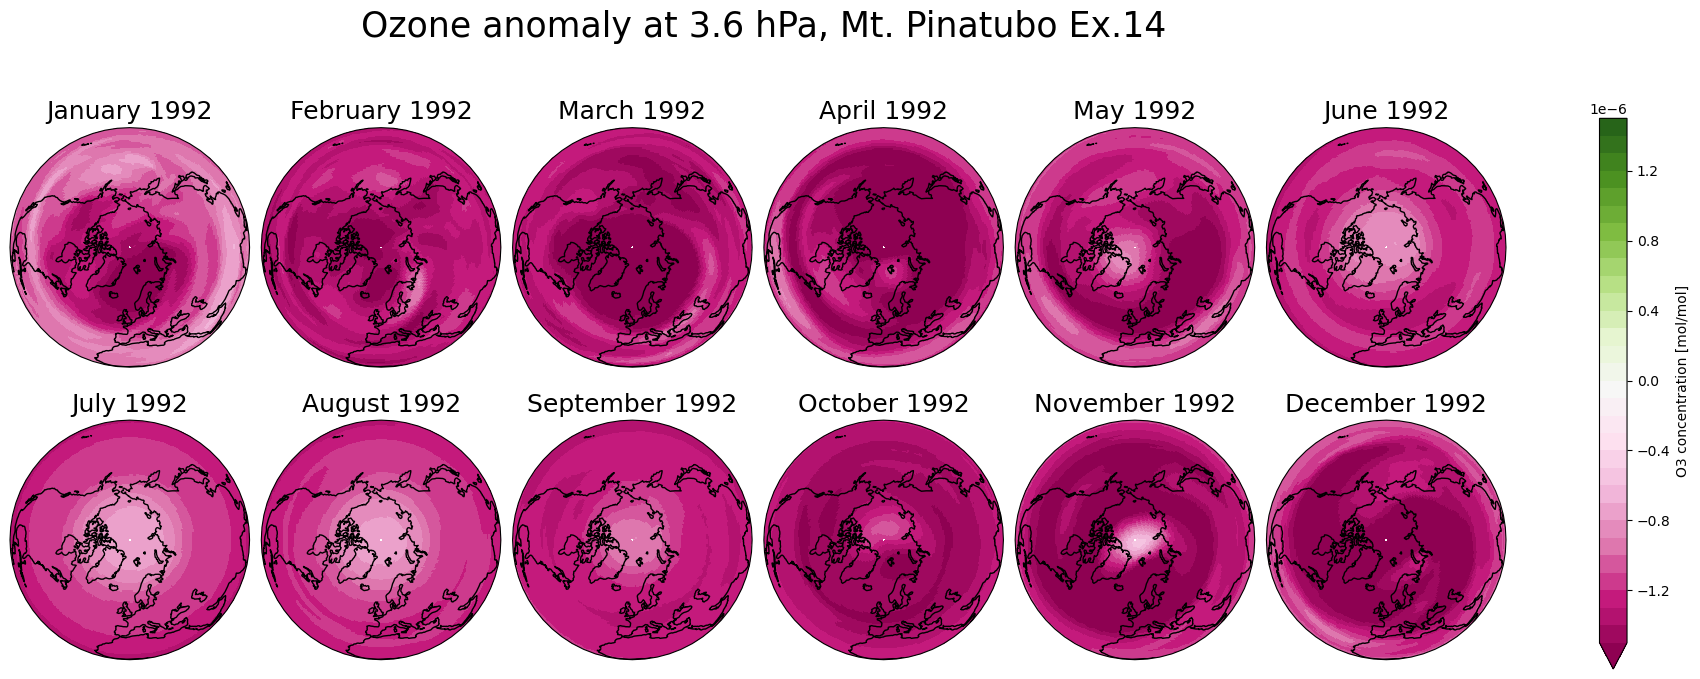

In [38]:
anom14=calc_monthly_anomaly(dso3_lev_14,1990)
north_multi_plot(anom14,1992,'PiYG','Ozone anomaly at 3.6 hPa, Mt. Pinatubo Ex.14')

In [39]:
dso3_16= xr.open_dataset(s3.open(o3_16))
dso3=dso3_16['O3']
dso3_lev_16=dso3.sel(lev=3.6, method='nearest').drop('lev')

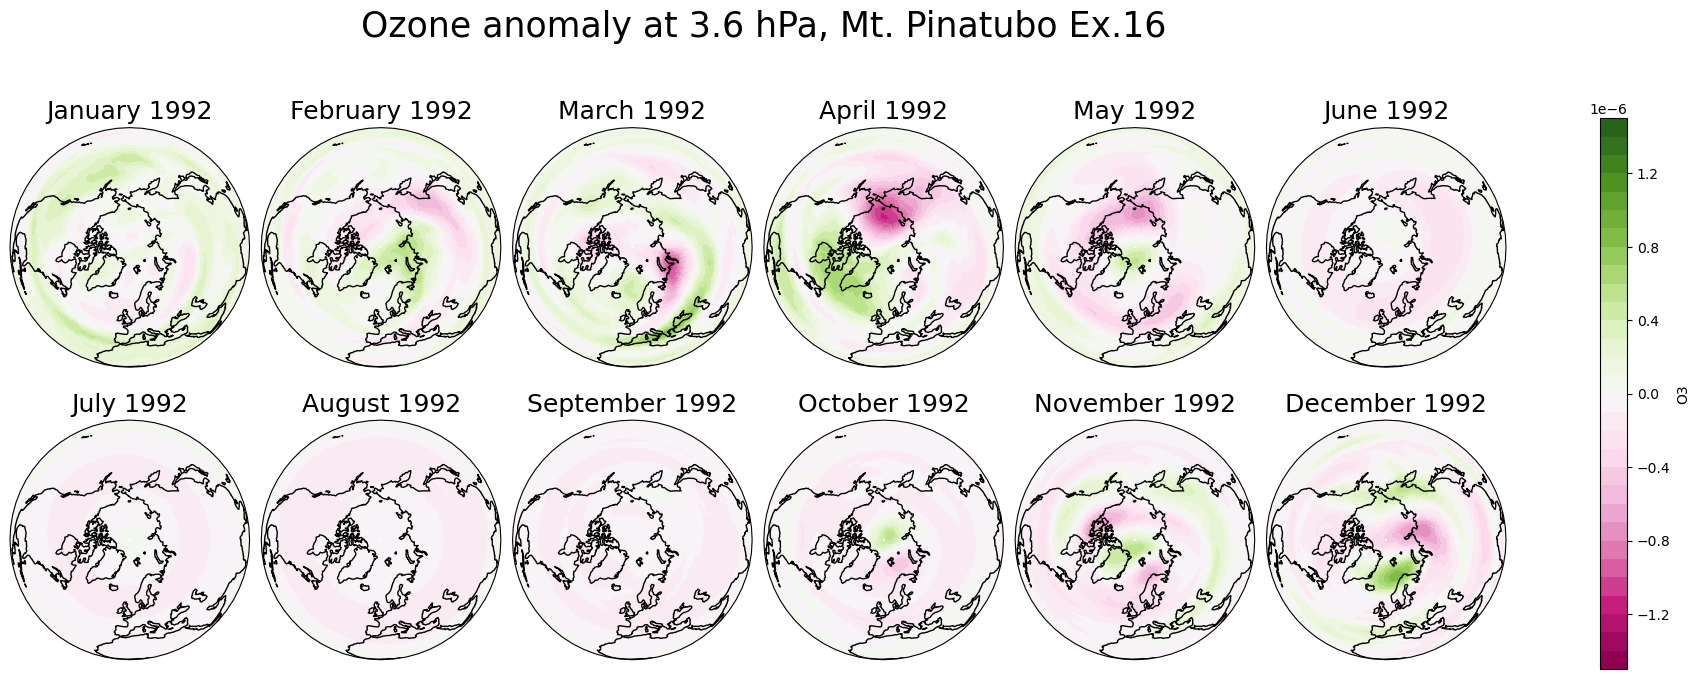

In [40]:
anom16=calc_monthly_anomaly(dso3_lev_16,1990)
anom_diff=anom14-anom16
north_multi_plot(anom_diff,1992,'PiYG','Ozone anomaly at 3.6 hPa, Mt. Pinatubo Ex.16')

In [21]:
dso3_pre= xr.open_dataset(s3.open(o3_pre))
dso3_pre.time.values;
dso3_p=dso3_pre['O3']
dso3_lev_pre=dso3_p.sel(lev=3.6, method='nearest').drop('lev')

<xarray.DataArray 'O3' (time: 600, lat: 192, lon: 288)>
[33177600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-02-01 00:00:00 ... 1900-01-01 00:00:00
Attributes:
    mdims:         1
    units:         mol/mol
    long_name:     O3 concentration
    cell_methods:  time: mean

In [20]:
anompre=calc_monthly_anomaly(dso3_lev_pre,1884)
north_multi_plot(anompre,1884,'PiYG','Ozone anomaly at 3.6 hPa, Mt. Pinatubo Ex.16')

ValueError: Only 1d and 2d plots are supported for facets in xarray. See the package `Seaborn` for more options.

### **4.0 Conclusion**

text